In [0]:
# collab:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

# Частично идея/текст этого семинара взята с седьмого семинара про авторегрессионным моделям на курсе дл у Осокина

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1MB 20kB/s 
     |████████████████████████████████| 8.8MB 2.1MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0


# Домашнее задание

В этой домашней работе вам будет необходимо написать не PixelCNN, а [Gated PixelCNN](https://arxiv.org/pdf/1606.05328.pdf)

Главные изменения:

1. Gated CNN
2. Blind spots
3. Skip connections


#### Gated CNN

Авторы утверждают что в качестве генерации PixelRNN побеждает PixelCNN в том числе и из за того что там есть "multiplicative units"(LSTM gates), которые помогают получать более сложные зависимости. 

$$y = \tanh(conv_1(x)) * \sigma(conv_2(x))$$

Здесь вам нужно переписать свою модель так, чтобы вместо ваших ReLU были вот такие Gated CNN юниты. 

_Подсказка: их можно описать как:_
1. conv -> сплит по каналам -> tanh * sigma
2. conv1 -> tanh, conv2 -> sigma, tanh * sigma


#### Blind Spot

Еще раз напомню, что наша маска выглядит как-то вот так: ![image.png](http://sergeiturukin.com/assets/2017-02-23-132528_231x241_scrot.png)

Авторы стать заметили, что с использованием такой маски, слой $L$ будет получать "неполную" информацию со слоя $L-1$

![image.png](http://sergeiturukin.com/assets/b7OpGQ.gif)

То есть когда мы генерируем центральный пиксель, мы не используем крайние правые пиксели. Чем глубже сеть, тем сильнее это выражается

![image.png](http://sergeiturukin.com/assets/blind_spot_missing.png)

Решение - разбить операцию свертки на две ![image](http://sergeiturukin.com/assets/2017-02-23-133739_307x163_scrot.png)

Подробнее про это вы можете прочитать вот [тут](http://sergeiturukin.com/2017/02/24/gated-pixelcnn.html)

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from IPython.display import clear_output

%matplotlib inline

Код снизу:
1. Клонит репозиторий с кодом для обработки постеров
2. Скачивает 40к постеров
3. Откладывает 100 постеров в валидационную папочку

In [0]:
%%capture
!git clone https://github.com/benckx/dnn-movie-posters.git
!cd dnn-movie-posters && python3 ./get_data.py -download

data_path = "./dnn-movie-posters/data/images/"
val_data_path = './dnn-movie-posters/data/val/'

val_files = os.listdir(data_path + '100/')[-100:]
os.makedirs(val_data_path, exist_ok=True)
os.makedirs(val_data_path + '100/', exist_ok=True)
for file in val_files:
  os.rename(data_path + '100/' + file, val_data_path + '100/'+ file)


In [0]:
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_buckets = 10

original_shape = [268, 182]
resize_n = 3


In [0]:
def bucketize(x):
    return (x*(num_buckets-1)).round()

In [0]:
poster_transforms = transforms.Compose([ 
    transforms.Resize([int(original_shape[0]/resize_n), int(original_shape[1]/resize_n)]),
    transforms.Grayscale(),
    transforms.ToTensor(), # PIL Image -> Tensor
    transforms.Lambda(lambda x: bucketize(x)),
])

In [0]:
data_path = "./dnn-movie-posters/data/images/"
val_data_path = './dnn-movie-posters/data/val/'


train_dataset = datasets.ImageFolder(data_path, transform=poster_transforms)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

val_dataset = datasets.ImageFolder(val_data_path, transform=poster_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)


In [0]:
image, _ = next(iter(train_loader))
image.shape

torch.Size([32, 1, 89, 60])

In [14]:
def plot_image(image, cmap=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image.detach().cpu().permute(1, 2, 0).squeeze(), cmap=cmap)
    plt.show()


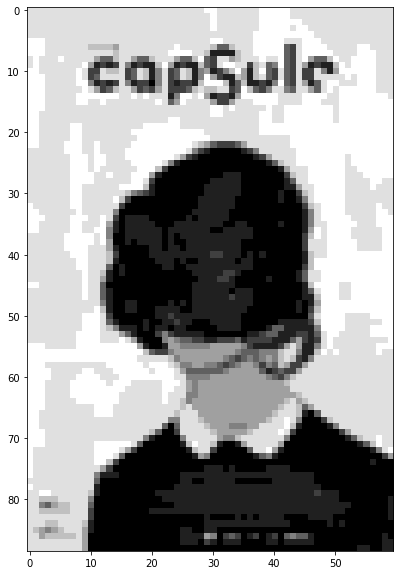

In [0]:
plot_image(image[0], cmap='gray')

In [0]:
def make_mask(include_center, height, width):
    mask = torch.ones(height, width).long()
    center = (int(height/2) + 1,int(width/2) + 1)
    mask[center[0]:] = 0
    mask[center[0]-1][center[1]-1:] = 0
    if include_center:
        mask[center[0]-1,center[1]-1] = 1
    else:
        mask[center[0]-1,center[1]-1] = 0
    return mask

In [0]:
class MaskedCNN(nn.Conv2d):
    def __init__(self, include_center, *args, **kwargs):
        super(MaskedCNN, self).__init__(*args, **kwargs)
        self.include_center = include_center
        self.register_buffer('mask', self.weight.data.clone())

        _, depth, height, width = self.weight.size()
        self.mask.fill_(1)
        self.mask[:,:] = make_mask(self.include_center, height, width)

    def forward(self, x):
        self.weight.data*=self.mask
        return super(MaskedCNN, self).forward(x)

In [7]:
class GatedBlock(nn.Module):
    def __init__(self, size, channels, in_channels = 1, bias = True, include_center = False):
        super(GatedBlock,self).__init__()
        self.size = size
        self.include_center = include_center
        self.conv1x1_v = nn.Conv2d(channels*2,channels*2,(1,1), bias = bias)
        self.conv1x1_h = nn.Conv2d(channels,channels,(1,1),bias = bias)

        if include_center:
            self.horizontal_stack = nn.Conv2d(channels,channels*2,(1,size//2+1),padding=(0,size//2), bias = bias)
            self.vertical_stack = nn.Conv2d(channels, channels*2,(size//2 + 1,size),padding=(size//2,(size-1)//2),bias = bias)        
        else:
            self.horizontal_stack = nn.Conv2d(in_channels,channels*2,(1,size//2+1),padding = (0,size//2 + 1),bias = bias)
            self.vertical_stack = nn.Conv2d(in_channels, channels*2,(size//2 + 1,size),padding=(size//2 + 1,(size-1)//2),bias = bias)

    def gate(self,a,b):
        return torch.sigmoid(a) * torch.tanh(b)
    
    def forward(self, v, h):
        out_v = self.vertical_stack(v)
        out_h = self.horizontal_stack(h)
        if self.include_center:
            out_v = out_v[:,:,:-(self.size//2),:]
            out_h = out_h[:,:,:,:-(self.size//2)]
        else:
            out_v = out_v[:,:,:-(self.size//2+2),:]
            out_h = out_h[:,:,:,:-(self.size//2+2)]   

        out_to_h = self.conv1x1_v(out_v)
        out_h = (out_to_h + out_h)
        out_v_tanh, out_v_sigm = torch.chunk(out_v,2,1)
        #gated_v = self.sigmoid_v(out_v_sigm) * self.tanh_v(out_v_tanh) 
        gated_v = self.gate(out_v_sigm, out_v_tanh)
        out_h_tanh, out_h_sigm = torch.chunk(out_h,2,1)
        #gated_h = self.sigmoid_h(out_h_sigm) * self.tanh_h(out_h_tanh)
        gated_h = self.gate(out_h_sigm, out_h_tanh)
        out_h = self.conv1x1_h(gated_h)
        if self.include_center:
            out_h = out_h + h
        return gated_v, out_h

In [8]:
gated = GatedBlock(7,32,bias = False, include_center= False)
gated_center = GatedBlock(5,32,bias = False, include_center= True)

In [9]:
for param in gated.parameters():
    param.data.fill_(1)
for param in gated_center.parameters():
    param.data.fill_(1)

In [10]:
x = torch.zeros((1,1,90,60))
x[:,:,30,30] = 1000

In [11]:
v = x
h = x
v, h = gated(v,h)

In [12]:
for _ in range(25):
    v, h = gated_center(v,h)

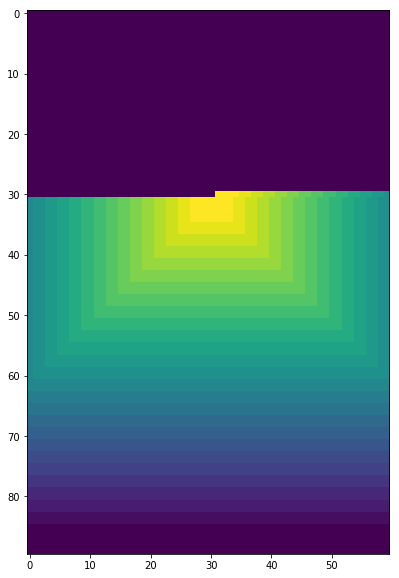

In [15]:
plot_image(h[:,1,:,:]) #No blind spots and no violations of autoregressive rule!!

In [0]:
class PixelCNN(nn.Module):
    def __init__(self, internal_channels, input_channels=1, num_pixels=10):
        super(PixelCNN,self).__init__()
        self.first = GatedBlock(5,internal_channels,include_center = False)
        self.layers = nn.ModuleList([GatedBlock(5,internal_channels,include_center =True) for i in range(20)])
        self.final_conv = nn.Conv2d(internal_channels,10,(1,1), padding=0) 

    def forward(self, x):
        x = x.float()
        v, h = self.first(x,x)
        for layer in self.layers:
            v, h = layer(v, h)
        out = self.final_conv(h)
        #out = F.relu(out)
        return out
        
    def generate_samples(self, starting_image, starting_point=(0, 0), arg = True):
        self.eval()
        # YOUR CODE
        for i in range(starting_point[0],starting_image.shape[2]):
            for j in range(starting_point[1],starting_image.shape[3]):
                logits = self(starting_image)
                logit = logits[:,:,i,j]
                if arg:
                    sample = torch.argmax(logit,1)
                    sample = sample.unsqueeze(1)
                else:
                    sample = torch.multinomial(nn.functional.softmax(logit,1),1)
                starting_image[:,:,i,j] = sample
        return starting_image


In [0]:
def plot_losses(losses):
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.show()

In [0]:
model = PixelCNN(32).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [0]:
%%capture
model.train()

In [0]:
logits = model(image.to(device))
logits.shape

torch.Size([32, 10, 89, 60])

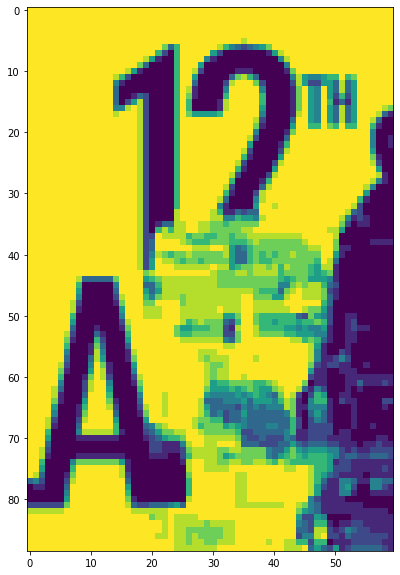

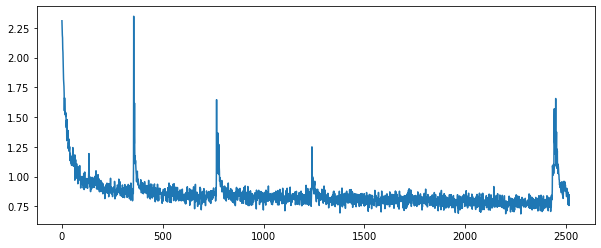

In [0]:
losses = []
starting_x, starting_y = 30, 20

for i in range(3):
    model.train()
    for ind, (image, _) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        optimizer.zero_grad()
        image = image.to(device)
        logits = model(image)
        loss = criterion(logits,
                         image.long().squeeze())
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    clear_output()
    model.eval()
    image, _ = next(iter(val_loader))
    starting_image = image.clone()
    starting_image[:, :, starting_x:, starting_y:] = 0
    sample = model.generate_samples(starting_image[:2].to(device), (starting_x, starting_y),arg = False)
    plot_image(sample[0])
    plot_losses(losses)
    

In [0]:
model.eval()
starting_image = image[:8].clone()
starting_image[:, :, 30:, 30:] = 0
sample = model.generate_samples(starting_image.to(device), starting_point=(30, 30),arg=False)

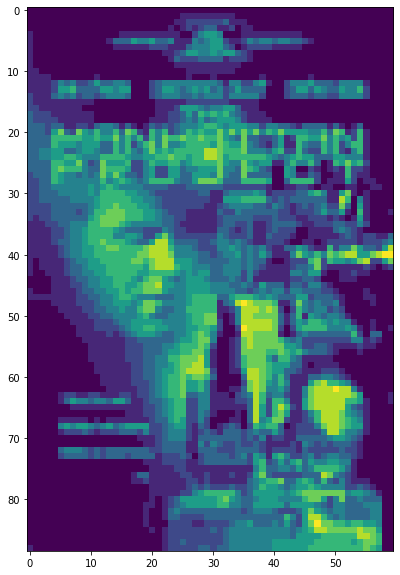

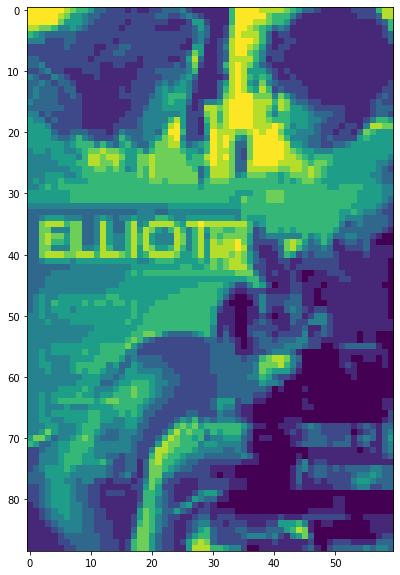

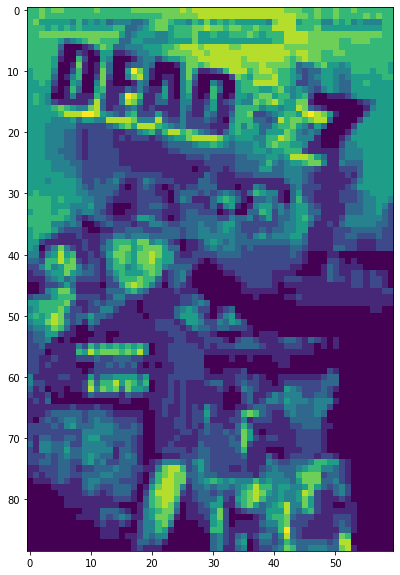

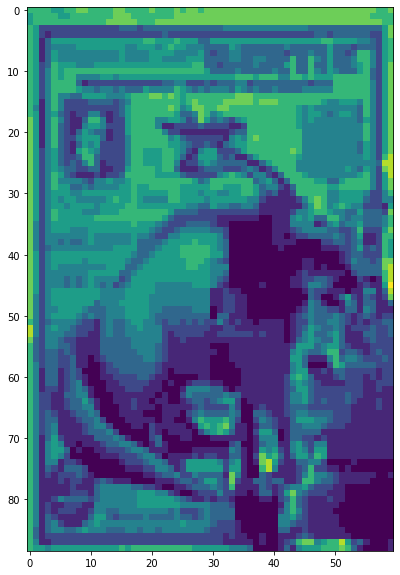

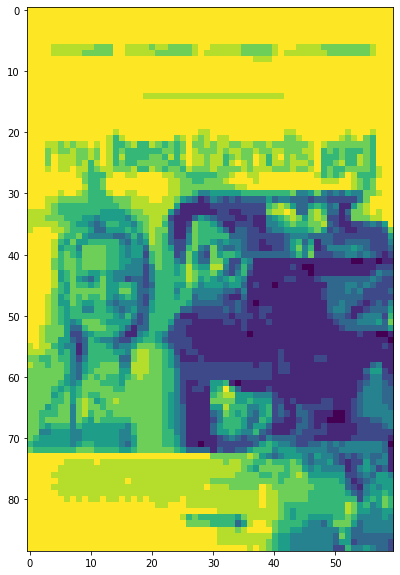

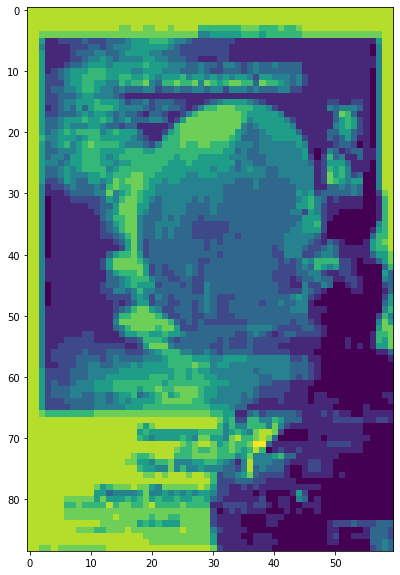

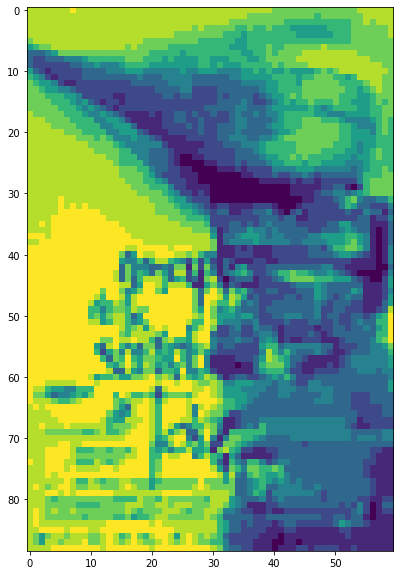

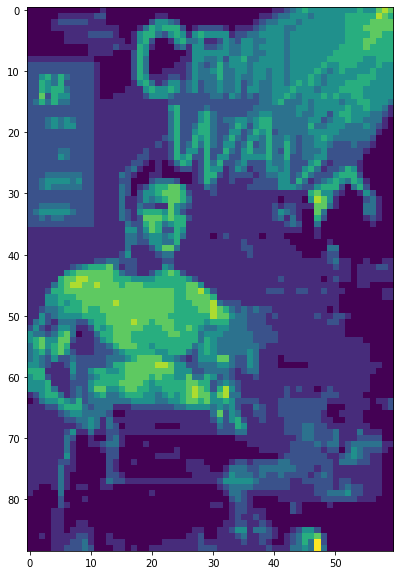

In [0]:
for i in sample:
    plot_image(i)

Баллы за домашку будут выдаваться за:
1. Реализацию Gated CNN
2. Реализацию маски без blind spot
3. Хорошие сгенерированные постеры
4. Сравнение PixelCNN с PixelCNN + улучшения

Дополнительно много баллов дадим если вы напишете PixelCNN++ и получите хорошие результаты на постерах


Продолжение такой идеи называется PixelCNN++

очень понятно описано вот тут:

https://github.com/Rayhane-mamah/Tacotron-2/issues/155